In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader
from src.kernel import L_Kernel
from src.sqw import SpecNeuralRepr
from kernel_learning import *
from src.data_utils import get_neighbors
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

Load trained model

In [4]:
### load data and forward model##########
data_path = '/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_ML.pt'
data_dict = torch.load(data_path,weights_only=False)
print(data_dict.keys())

### old training########################
best_ckpt = '/pscratch/sd/y/yn754/data/S2e/input/version_14896845/checkpoints/epoch=7160-step=343728.ckpt' #checkpoint for forward model
model_sqw0 = load_trained_model(best_ckpt) #specify forward model
model_sqw0.params = torch.tensor([29, 1.7])
#########################################

### load from new checkpoint ##########
#checkpoint_dir = '/global/homes/y/yn754/kernel-s2e/lightning_logs/version_24/checkpoints/'
checkpoint_dir = '/pscratch/sd/y/yn754/data/S2e/checkpoints/lightning_logs/version_0/checkpoints/'
ckpt_path = checkpoint_dir + 'epoch=49-step=50000.ckpt'
#######################################

model_sqw = SpecNeuralRepr()
model_sqw.params = torch.tensor([29, 1.7])
model = L_Kernel.load_from_checkpoint(ckpt_path,forward_model = model_sqw )
model_sqw = model.forward_model 
model_sqw.params

model_config = torch.load(ckpt_path)['hyper_parameters']['model_config']
model.load_state_dict(torch.load(ckpt_path)['state_dict'])

dict_keys(['grid', 'S', 'background', 'background_dict'])


/tmp/ipykernel_326394/3959172379.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_config = torch.load(ckpt_path)['hyper_parameters']['model_config']
/tmp/ipykernel

<All keys matched successfully>

In [5]:
model_config

{'dim': 4,
 'neighbor_range': 1,
 'exclude_corner': True,
 'hidden_dim': 256,
 'num_layers': 3,
 'scale_factor_initial': 300.0}

In [6]:
hklw_grid = torch.vstack([_.unsqueeze(0) for _ in torch.meshgrid(*[v for k, v in data_dict['grid'].items()], indexing='ij')]).permute(1, 2, 3, 4, 0)

In [7]:
dataset = NeighborDataset(hklw_grid, data_dict['S'], neighbor_range=model_config['neighbor_range'])
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [8]:
print(model.kernel_net.scale_factor)

Parameter containing:
tensor(300., device='cuda:0', requires_grad=True)


In [9]:
batch = next(iter(dataloader))
center_pts = batch['center_pts']

In [10]:
from src.qpath import linspace_2D_equidistant

kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = data_dict['grid']['w_grid']
qw_coords = []
for _l in data_dict['grid']['l_grid']:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)
    
_l = data_dict['grid']['l_grid'][0]

params = torch.tensor([29, 1.7])

# x_input = torch.zeros(wpts.shape[0], kpts.shape[0], 6)
# x_input[...,:4] = torch.cat([
#     kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
#     _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
#     wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
#    ], dim=2)
# x_input[...,4:] = params


center_pts = torch.vstack([_.unsqueeze(0) for _ in qw_coords])

In [11]:
s_sig = torch.zeros(center_pts.view(-1, 4).shape[:-1]+(1,))
s_bkg = torch.zeros_like(s_sig)

In [12]:
from src.experiment import NeutronExperiment


experiment_config = {
    "q_grid": tuple([data_dict['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data_dict['grid']['w_grid'],
    "S_grid": data_dict['S'],
    "S_scale_factor": 1.
}

experiment = NeutronExperiment(**experiment_config)
# experiment.prepare_experiment(hklw_grid)

Process data for plotting

In [ ]:
batches = np.array_split(np.arange(center_pts.view(-1,4).shape[0]), 10)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts.view(-1,4)[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=model_config['dim'], neighbor_range=model_config['neighbor_range'], exclude_corner=model_config['exclude_corner'], deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = model.kernel_net(_center_pts.to(model.dtype).to(model.device))
        _s_bkg = model.bkgd_net(_center_pts.to(model.dtype).to(model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

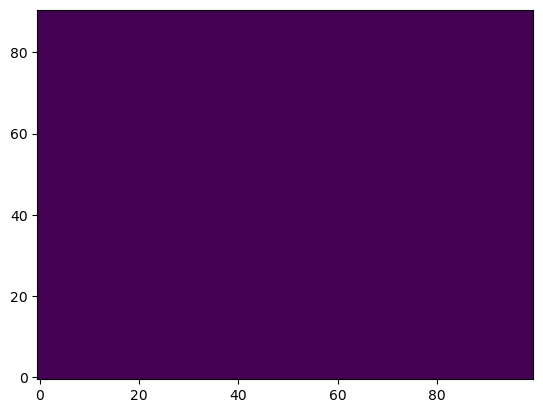

In [24]:
plt.imshow(s_bkg.reshape(center_pts.shape[:-1]).detach().cpu().sum(0), origin='lower', aspect='auto', vmax=20)

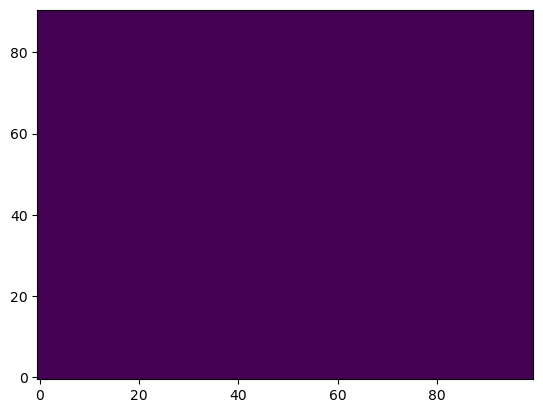

In [25]:
plt.imshow(s_sig.reshape(center_pts.shape[:-1]).sum(0), origin='lower', aspect='auto')

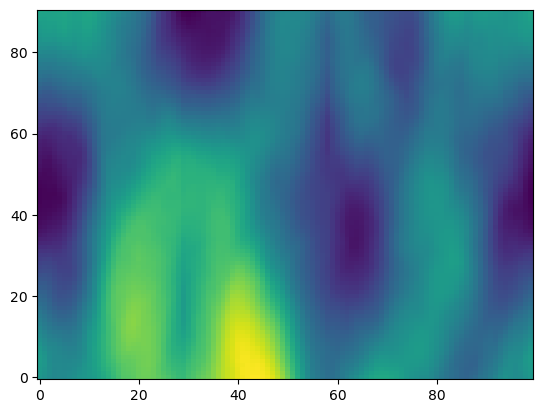

In [27]:
plt.imshow(model_sqw.forward_qw(center_pts.to(model_sqw.device)).cpu().sum(0), origin='lower', aspect='auto')

In [28]:
S_exp = 0.
mask_exp = 0.
for _qw_coords in qw_coords:
    S_exp += experiment.get_measurements_on_coords(_qw_coords)
    mask_exp += experiment.get_mask_on_coords(_qw_coords)

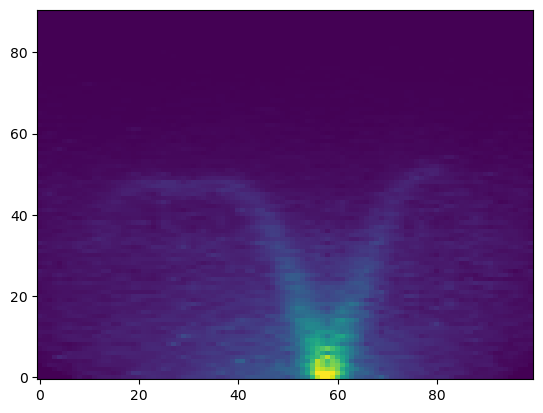

In [29]:
plt.imshow(S_exp, origin='lower', aspect='auto', vmax=300)

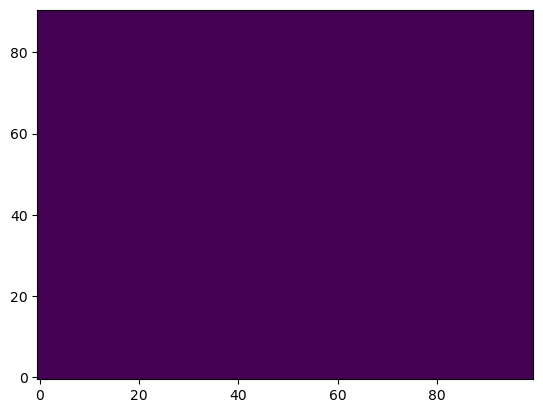

In [30]:
S_exp_pred = (s_sig+s_bkg).reshape(center_pts.shape[:-1]).detach().cpu().sum(0)
plt.imshow(S_exp_pred, origin='lower', aspect='auto', vmax=300)

/tmp/ipykernel_2022052/3201296619.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(S_exp_pred - S_exp), origin='lower', aspect='auto')


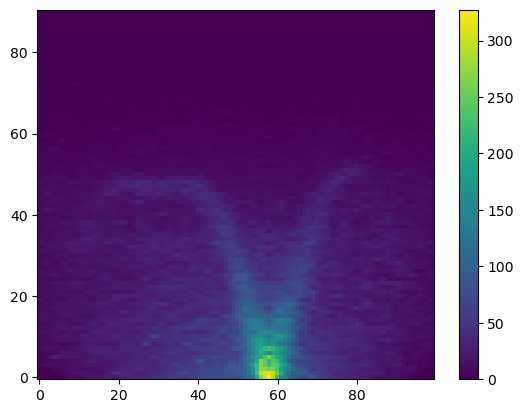

In [31]:
plt.imshow(np.abs(S_exp_pred - S_exp), origin='lower', aspect='auto')
plt.colorbar()

In [32]:
S_mask = data_dict['S'] > 1e-3

In [33]:
batches = np.array_split(torch.where(S_mask.reshape(-1))[0], 2500)

In [36]:
center_pts_full_grid = hklw_grid.reshape(-1,4)
s_sig_full_grid = torch.zeros((data_dict['S'].numel(), 1,))
s_bkg_full_grid = torch.zeros_like(s_sig_full_grid)

batches = np.array_split(torch.where(S_mask.reshape(-1))[0], 2000)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts_full_grid[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=model_config['dim'], neighbor_range=model_config['neighbor_range'], exclude_corner=model_config['exclude_corner'], deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = model.kernel_net(_center_pts.to(model.dtype).to(model.device))
        _s_bkg = model.bkgd_net(_center_pts.to(model.dtype).to(model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig_full_grid[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg_full_grid[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

100%|██████████| 2000/2000 [02:30<00:00, 13.31it/s]


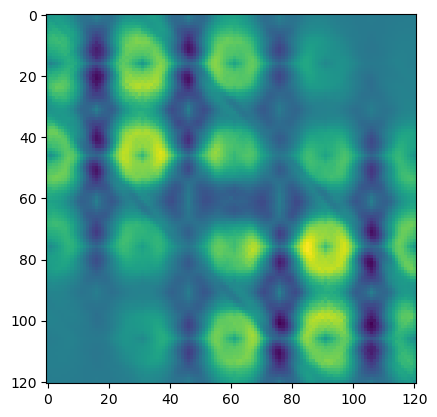

In [37]:
plt.imshow(s_sig_full_grid.reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))

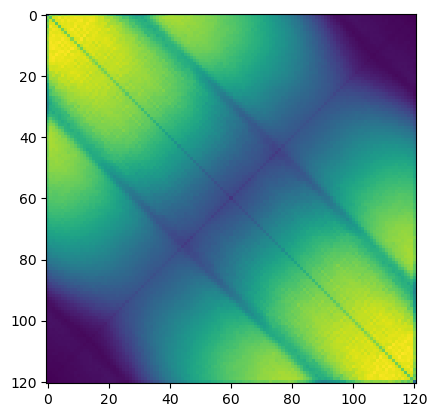

In [38]:
plt.imshow(s_bkg_full_grid.reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))

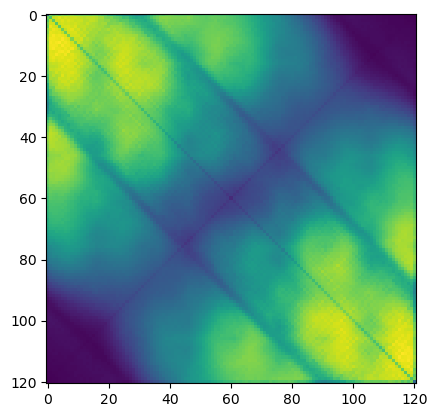

In [39]:
plt.imshow((s_bkg_full_grid+s_sig_full_grid).reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))